In [14]:
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import *

In [15]:
from tensorflow.keras.optimizers import Adam 
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Conv2DTranspose
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model

In [16]:
!nvidia-smi

Wed May  4 20:20:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
img_height, img_width = 256, 256
channels = 3

In [19]:
def decode_img(image):
    # convert to 3-channel
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    # scale to <-1,1>
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

In [20]:
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [21]:
list_ds = tf.data.Dataset.list_files('../input/imagenetsketch/sketch/*/*.JPEG', shuffle=True)
# batch images so they have the right shape for neural net
styled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1)

2022-05-04 20:20:29.417788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 20:20:29.540027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 20:20:29.541369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 20:20:29.544938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
def plot(image, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.imshow(image * 0.5 + 0.5)

2022-05-04 20:20:39.148976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


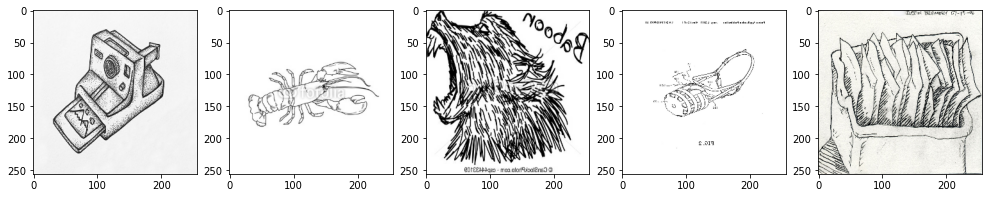

In [23]:
fix, axs = plt.subplots(1, 5, figsize=(17,17))
for batch, ax in zip(styled_ds.take(5), axs):
    plot(batch[0], ax)
plt.show()

In [24]:
list_ds = tf.data.Dataset.list_files('../input/gan-getting-started/photo_jpg/*.jpg', shuffle=True)
photo_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1)

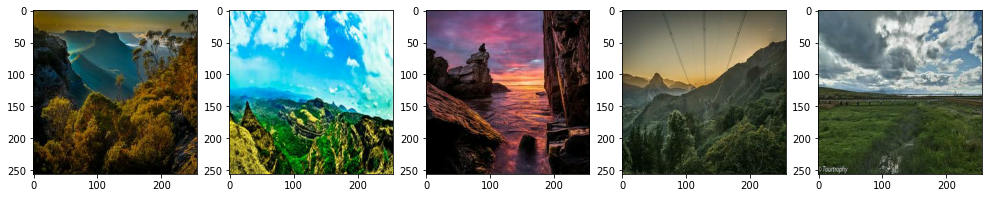

In [25]:
fix, axs = plt.subplots(1, 5, figsize=(17,17))
for batch, ax in zip(photo_ds.take(5), axs):
    plot(batch[0], ax)
plt.show()

In [26]:
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
#     in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = in_src_image
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model(in_src_image, patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

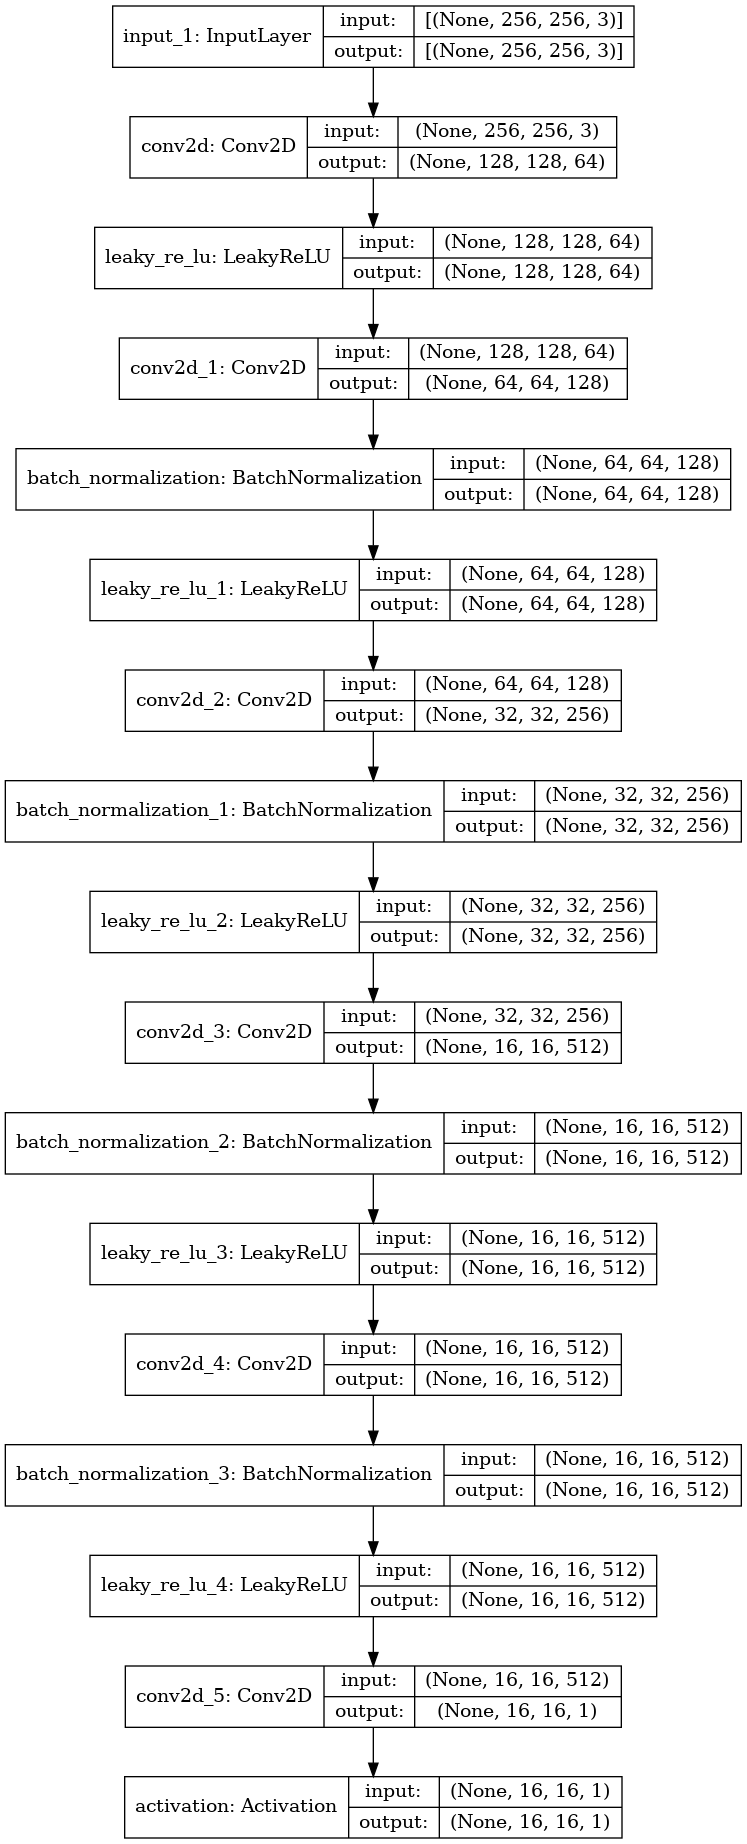

In [27]:
image_shape = (img_height, img_width,3)
d_model = define_discriminator(image_shape)
# summarize the model
d_model.summary()
# plot the model
plot_model(d_model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [29]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [30]:
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model
 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

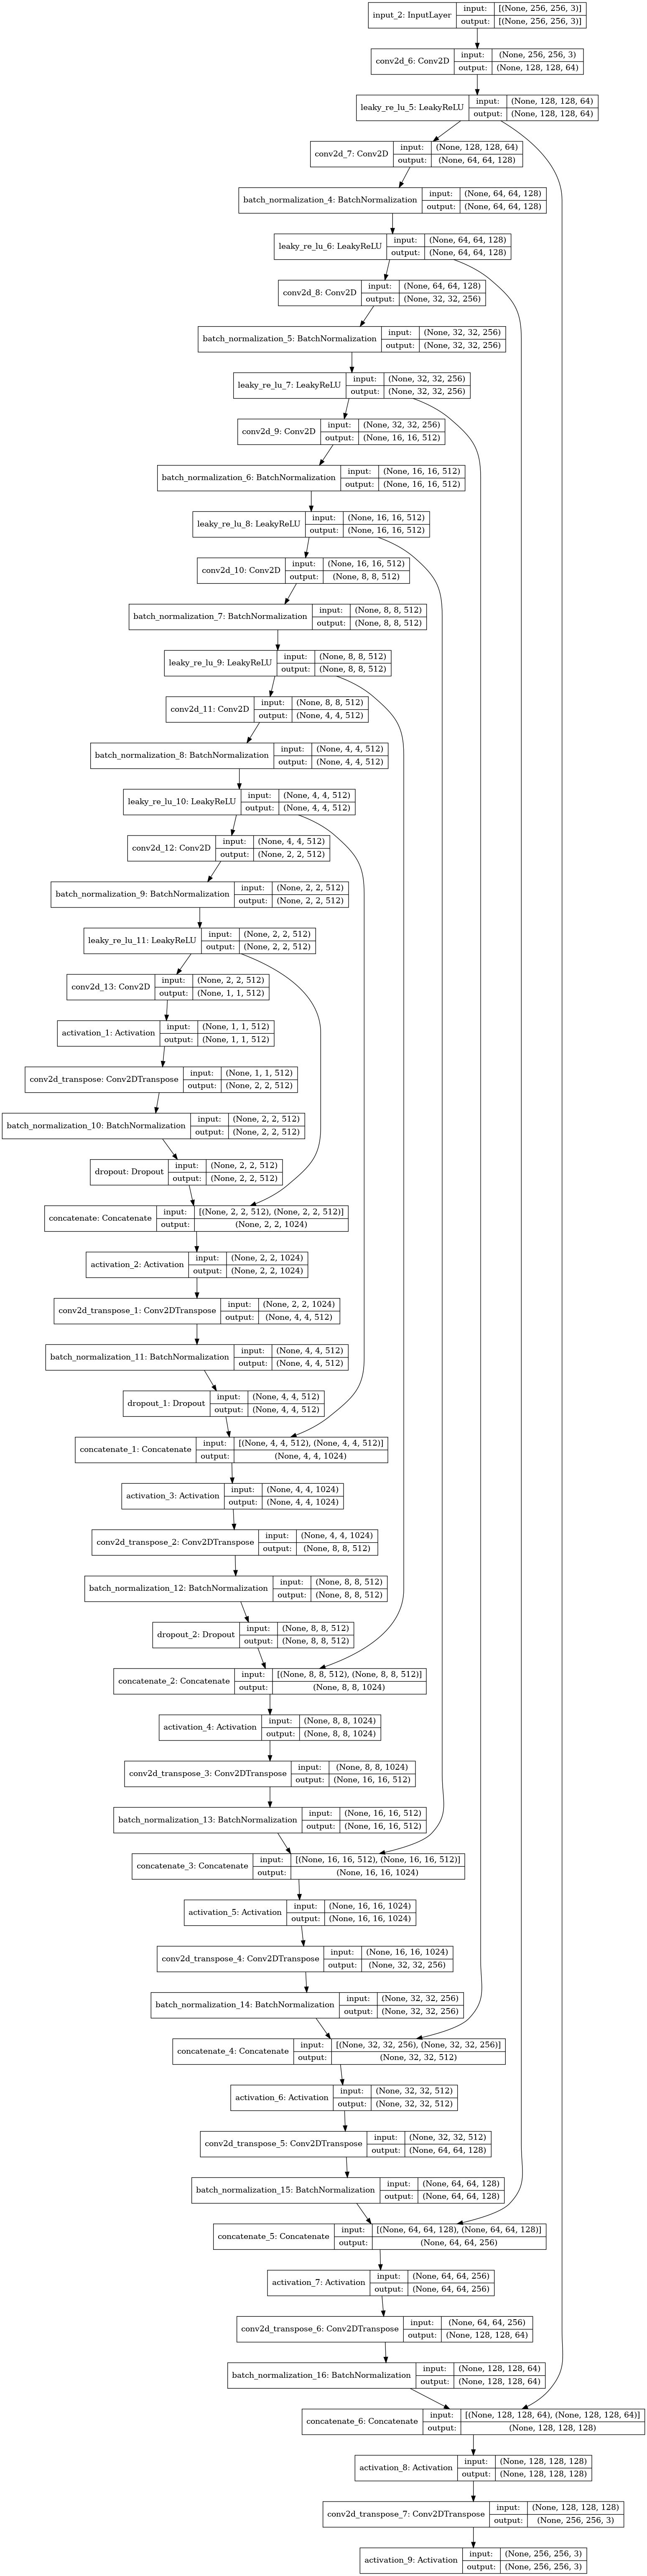

In [31]:
image_shape = (img_height, img_width,3)
# create the model
g_model = define_generator(image_shape)
# summarize the model
g_model.summary()
# plot the model
plot_model(g_model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)


In [32]:
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  54429315    input_3[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 16, 16, 1)    6965185     input_3[0][0]                    
                                                                 model_1[0][0]                    
Total params: 61,394,500
Trainable params: 54,422,275
Non-trainable params: 6,972,225
__________________________________________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


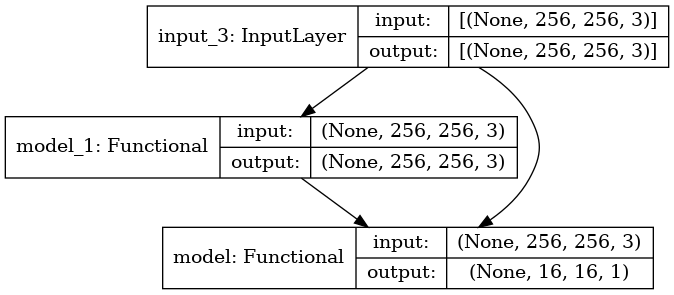

In [33]:
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
image_shape = (img_height, img_width,3)
with strategy.scope():
    styled_generator = define_generator(image_shape) # transforms photos to drawings
    photo_generator = define_generator(image_shape) # transforms drawings to photos

    styled_discriminator = define_discriminator(image_shape) # differentiates real and generated drawings
    photo_discriminator = define_discriminator(image_shape) # differentiates real and generated photos


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [35]:
class CycleGan(keras.Model):
    def __init__(
        self,
        styled_generator,
        photo_generator,
        styled_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.s_gen = styled_generator
        self.p_gen = photo_generator
        self.s_disc = styled_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        s_gen_optimizer,
        p_gen_optimizer,
        s_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.s_gen_optimizer = s_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.s_disc_optimizer = s_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        # @TODO: rename
        real_styled, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to styled back to photo
            fake_styled = self.s_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_styled, training=True)

            # styled to photo back to styled
            fake_photo = self.p_gen(real_styled, training=True)
            cycled_styled = self.s_gen(fake_photo, training=True)

            # generating itself
            same_styled = self.s_gen(real_styled, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_styled = self.s_disc(real_styled, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_styled = self.s_disc(fake_styled, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            styled_gen_loss = self.gen_loss_fn(disc_fake_styled)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_styled, cycled_styled, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_styled_gen_loss = styled_gen_loss + total_cycle_loss + self.identity_loss_fn(real_styled, same_styled, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            styled_disc_loss = self.disc_loss_fn(disc_real_styled, disc_fake_styled)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        styled_generator_gradients = tape.gradient(total_styled_gen_loss,
                                                  self.s_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        styled_discriminator_gradients = tape.gradient(styled_disc_loss,
                                                      self.s_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.s_gen_optimizer.apply_gradients(zip(styled_generator_gradients,
                                                 self.s_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.s_disc_optimizer.apply_gradients(zip(styled_discriminator_gradients,
                                                  self.s_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "styled_gen_loss": total_styled_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "styled_disc_loss": styled_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [36]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [37]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [38]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [39]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [40]:
with strategy.scope():
    styled_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    styled_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [41]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        styled_generator, photo_generator, styled_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        s_gen_optimizer = styled_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        s_disc_optimizer = styled_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [42]:
len(photo_ds), len(styled_ds)

(7038, 50889)

In [43]:
class ShowSamplesCallback(keras.callbacks.Callback):
    def __init__(self, save_to_dir: str):
        self.save_to_dir = save_to_dir
    
    def on_train_begin(self, logs=None):
        self.original = []
        self.styled = []
    
    def on_train_end(self, logs=None):
        if self.save_to_dir:
            dir_ = Path(self.save_to_dir)
            dir_.mkdir(parents=True, exist_ok=True)
            for i, (original, styled) in enumerate(zip(self.original, self.styled)):
                tf.keras.preprocessing.image.save_img(dir_ / f'{i + 1}_original.jpg', original)
                tf.keras.preprocessing.image.save_img(dir_ / f'{i + 1}_styled.jpg', styled)
    
    def on_epoch_end(self, epoch, logs=None):
        styled_generator = self.model.s_gen
        # sample predict
        img_batch = next(iter(photo_ds.take(1)))
        prediction = styled_generator(img_batch, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = img_batch[0]
        img = (img * 127.5 + 127.5).numpy().astype(np.uint8)
        self.original.append(img)
        self.styled.append(prediction)
        
        # plot
        fig, axs = plt.subplots(1, 2, figsize=(6,6), squeeze=True)
        axs[0].imshow(img)
        axs[1].imshow(prediction)
        axs[0].set_title("Input Photo [{:02d}]".format(epoch + 1))
        axs[1].set_title("Generated [{:02d}]".format(epoch + 1))
        axs[0].axis("off")
        axs[1].axis("off")
        plt.show()

In [44]:
class SaveGeneratorCallback(keras.callbacks.Callback):
    def __init__(self, epochs: int, path: str):
        self.epochs = epochs
        self.dir_ = Path(path)
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epochs == 0:
            styled_generator = self.model.s_gen
            path = self.dir_ / f'weights.{epoch + 1}.hdf5'
            print(f'[SaveGeneratorCallback] Saving weights to {path}.')
            styled_generator.save_weights(path)

In [45]:
HOUR_TO_SECONDS = 3600

In [46]:
epoch = 1

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
2022-05-04 20:21:31.930973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1501 of 3000
2022-05-04 20:21:41.473177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-05-04 20:21:51.747428: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1000/1000 [==============================] - 292s 245ms/step - styled_gen_loss: 7.4589 - photo_gen_loss: 6.8787 - styled_disc_loss: 0.4378 - photo_disc_loss: 0.5946


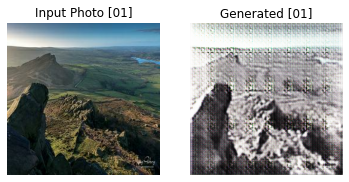

[SaveGeneratorCallback] Saving weights to /kaggle/working/weights.1.hdf5.


In [ ]:
_buffer_size = 3000

history = cycle_gan_model.fit(
    # zipped dataset - infinitely repeating
    tf.data.Dataset.zip((
        # buffer_size should be at least the size of the dataset for uniform shuffling
        # - https://stackoverflow.com/a/47025850/3936732
        # - however the dataset is too large for that so we limit the size
        styled_ds.shuffle(_buffer_size, reshuffle_each_iteration=True).repeat(),
        photo_ds.shuffle(_buffer_size, reshuffle_each_iteration=True).repeat(),
    )),
    
    steps_per_epoch=1000, # batches per epoch
    epochs=epoch,
    # --- callbacks ---
    callbacks=[
        tfa.callbacks.TimeStopping(seconds=HOUR_TO_SECONDS * 6, verbose=1),
        ShowSamplesCallback('/kaggle/working/imgs'),
        SaveGeneratorCallback(50, '/kaggle/working'),
              ],
)